In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.stats.proportion as proportion
import seaborn as sns
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare
import numpy as np
import statsmodels.stats.power as smp

In [70]:
# создаем датафреймы из всех csv файлов.
active_studs = pd.read_csv('active_studs.csv')
checks = pd.read_csv('checks.csv', sep=';')
groups = pd.read_csv('groups.csv', sep = ';')

In [71]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [72]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [73]:
groups.head()

,id,grp
0,1206794,B
1,331024,B
2,1733498,A
3,161574,B
4,168443,B


In [37]:
# создаем один датафрейм со всеми данными.
data = pd.merge(active_studs, groups, how = 'left', left_on = 'student_id', right_on= 'id')
data = pd.merge(data, checks, how = 'left', left_on = 'student_id', right_on= 'student_id')

In [38]:
# убираем дубликат столбца с id.
data.drop('student_id', axis=1, inplace=True)

In [40]:
# создан полный датафрейм со всеми данными из трех csv файлов.
data.head() 

,id,grp,rev
0,581585,A,NaN
1,5723133,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN


In [41]:
# создадим новую колонку, где 0 - пользователь не совершал покупку, 1 - пользователь совершил покупку.
data['created_order'] = data['rev'].apply(lambda x: 1 if x > 0 else 0)
data

,id,grp,rev,created_order
0,581585,A,NaN,0
1,5723133,A,NaN,0
2,3276743,B,NaN,0
3,4238589,A,NaN,0
4,4475369,B,NaN,0
...,...,...,...,...
8336,1794344,B,NaN,0
8337,296883,B,NaN,0
8338,3598448,B,NaN,0
8339,3610547,B,290.0,1


In [42]:
# делаем группировку и смотрим количество студентов, сумму выручки в контрольной и целевой группе, 
# и количество покупок в каждой группе.
metrics = data.groupby('grp', as_index=False).agg({'id': 'count', 'rev': 'sum', 'created_order' : 'sum'})
metrics

,grp,id,rev,created_order
0,A,1538,72820.0000,78
1,B,6803,394974.0035,314


In [43]:
# так же посчитаем конверсию в покупку.
metrics['conversion']=(metrics['created_order']/metrics['id'])*100
metrics

,grp,id,rev,created_order,conversion
0,A,1538,72820.0000,78,5.071521
1,B,6803,394974.0035,314,4.615611


In [44]:
# на данном этапе видно, что сегменты распределены не равномерно, а в группе А конверсия чуть выше.

In [45]:
chi2stat, pval, table = proportion.proportions_chisquare(metrics['created_order'],
                                                       metrics['id'])
print(pval)
alpha = 0.05
print(pval < alpha)

0.44547028437158964
False


In [46]:
# при уровне значимости в 5% статистически значимой разницы в конверсии между группами А и В нет, мы не можем сказать, 
# что конверсия в контрольной группе действительно выше.

In [47]:
# далее разделим пользователей на тестовую и котрольную группу, что бы посчитать как изменился средний чек покупки.
grp_a = data[data['grp'] == 'A']['rev'].dropna().values
grp_b = data[data['grp'] == 'B']['rev'].dropna().values

In [48]:
# получим массим данных с помощью функции bootstrap_ab
boot_res = bs.bootstrap_ab(test = grp_b, ctrl = grp_a,
                          stat_func = bs_stats.mean,
                          compare_func=bs_compare.difference,
                          return_distribution=True)

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


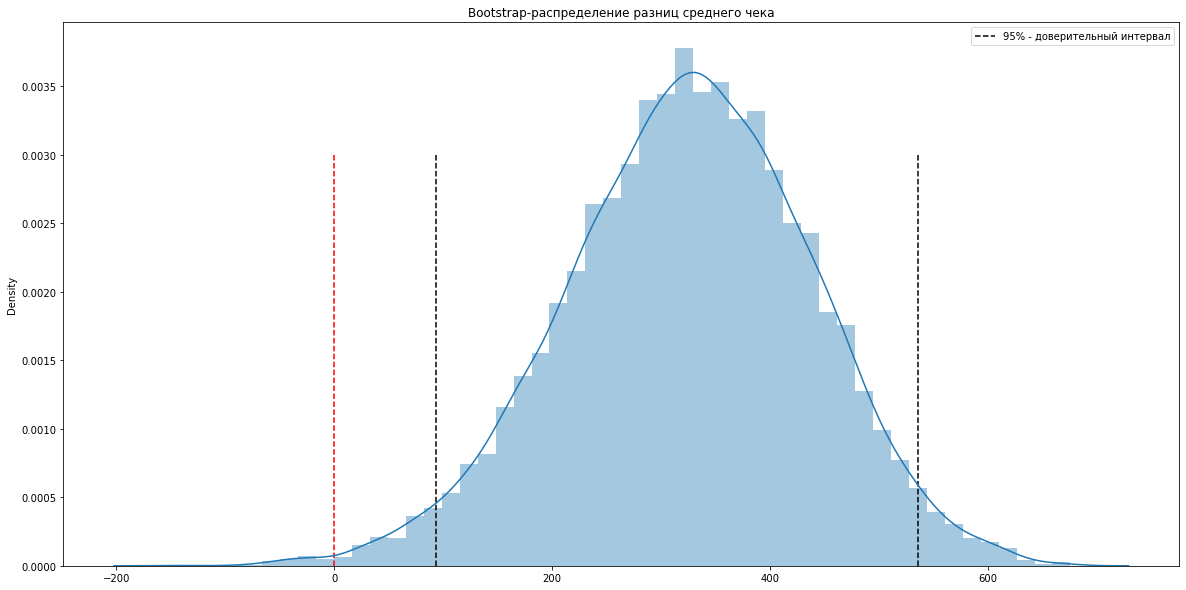

In [49]:
# полученный массив построим в виде графика, что бы увидеть, существует ли разница в сумме среднего чека.
sns.distplot(boot_res)
borders = np.percentile(boot_res,[2.5, 97.5])
plt.title('Bootstrap-распределение разниц среднего чека')
plt.rcParams['figure.figsize'] = (20,10)
plt.vlines(0, ymin = 0, ymax = 0.003, linestyle = '--', colors = 'red')
plt.vlines(borders, ymin = 0, ymax = 0.003, linestyle = '--', colors = 'black', label = '95% - доверительный интервал')
plt.legend()
plt.show()

In [50]:
# статистически значимая разница в тестовой группе присутствуют.
# Средний чек у пользователей из тестовой группы выше, чем у пользователей из контрольной группы.

In [52]:
metrics.head()

,grp,id,rev,created_order,conversion
0,A,1538,72820.0000,78,5.071521
1,B,6803,394974.0035,314,4.615611


In [ ]:
# функция для подсчета effect_size, для последующих операций
def chi2_effect_size(p0,p1):
    return np.sqrt(((p0-p1)**2 / p0))

In [53]:
conversion_control = metrics['conversion'][0]/100
conversion_test = metrics['conversion'][1]/100
nobs = min(metrics['id'])

In [57]:
smp.GofChisquarePower().solve_power(effect_size = chi2_effect_size(conversion_control, conversion_test),
                    nobs = nobs,
                    alpha = pval, 
                    power = None)

0.5720902277849201

In [ ]:
# мощность 57% , достаточно низкое значение, 
# в 43% случаев мы бы не увидели статистически значимых отличий там, где они существуют

In [ ]:
# можно посмотреть, какое количество наблюдений нужно, что бы получить желаемый уровень мощности (возьмем 80%)

In [59]:
power = 0.8

In [60]:
size_of_each_test_group = chipower.solve_power(effect_size=chi2_effect_size(conversion_control, conversion_test), 
                                               nobs = None,
                                               alpha = alpha,
                                               power = power)

In [69]:
# функция выдает nobs для каждой из групп, поэтому полученое значение умножаем на 2, и получаем необходимый размер выборки
# для эксперимента.
f'Необходимый размер выборки - {round(size_of_each_test_group*2)}' 

'Необходимый размер выборки - 38301'

In [ ]:
# Для качественного эксперимента нам нужно почти в 5 раз больше данных для оценки AB-теста

In [ ]:
# Мы можем смотреть на две метрики - конверсия и размер среднего чека.

# В результате эксперимента новую механику для всех пользователей можно запустить, так как не смотря на отсутствие статистической
# значимости в конверсии, вариант В показал лучший результат в размере среднего чека пользователя. 

# Если мы хотим получить более точные данные нужно провести повторное АВ-тестирование, и увеличить выборку 
# до 38301 наблюдений как минимум, а так же добавить данные о сегментации пользователей по городам и каналу привлечения, 
# и затем провести повторный анализ.